## 3rd International Workshop on AI in Networks and Distributed Systems (WAIN 2021)
> https://www.performance2021.deib.polimi.it/wain/


### Paper
> Improving detection of scanning attacks on heterogeneous networks with Federated Learning

### Authors
>
> Gustavo de Carvalho Bertoli
>
> Lourenço Alves Pereira Júnior
>
> Osamu Saotome

### Repository
>
> https://github.com/c2dc/wain2021
>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from tqdm.notebook import tqdm
from scipy.stats import ttest_ind
from sklearn.utils import resample
import random
from collections import defaultdict
from statistics import mean
from copy import deepcopy

# define a specific seed for reproductibility
seed=42

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 300)

%matplotlib inline

---
# Data Analysis

In [2]:
df = pd.read_csv('./Train_Test_Network_dataset/NF-ToN-IoT-v2.csv.gz')
df.head()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,MAX_TTL,LONGEST_FLOW_PKT,SHORTEST_FLOW_PKT,MIN_IP_PKT_LEN,MAX_IP_PKT_LEN,SRC_TO_DST_SECOND_BYTES,DST_TO_SRC_SECOND_BYTES,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,SRC_TO_DST_AVG_THROUGHPUT,DST_TO_SRC_AVG_THROUGHPUT,NUM_PKTS_UP_TO_128_BYTES,NUM_PKTS_128_TO_256_BYTES,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Attack,Label
0,192.168.1.193,49235,192.168.1.33,4444,6,0.0,155392,202,34552,149,24,24,24,4294952,15,15,128,128,1500,40,40,1500,155392.0,34552.0,0,0,0,0,77696000,17272000,56,150,36,14,95,45555,4805,0,0,0,0,0,0,ransomware,1
1,192.168.1.193,49228,192.168.1.152,1880,6,0.0,1600,40,35741,65,24,16,24,4294952,15,15,128,128,1286,40,40,1286,1600.0,35741.0,0,0,0,0,800000,17864000,47,3,30,19,6,16425,237,0,0,0,0,0,0,Benign,0
2,192.168.1.152,0,192.168.1.193,0,1,0.0,212,2,0,0,0,0,0,0,0,0,64,64,106,106,0,106,212.0,NaN,0,0,0,0,1696000,0,2,0,0,0,0,0,0,771,3,0,0,0,0,Benign,0
3,192.168.1.169,65317,239.255.255.250,1900,17,0.0,165,1,0,0,0,0,0,0,0,0,0,0,165,165,0,165,165.0,NaN,0,0,0,0,1320000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Benign,0
4,192.168.1.79,60766,192.168.1.255,15600,17,0.0,63,1,0,0,0,0,0,0,0,0,0,0,63,63,0,63,63.0,NaN,0,0,0,0,504000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,Benign,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16940496 entries, 0 to 16940495
Data columns (total 45 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   IPV4_SRC_ADDR                object 
 1   L4_SRC_PORT                  int64  
 2   IPV4_DST_ADDR                object 
 3   L4_DST_PORT                  int64  
 4   PROTOCOL                     int64  
 5   L7_PROTO                     float64
 6   IN_BYTES                     int64  
 7   IN_PKTS                      int64  
 8   OUT_BYTES                    int64  
 9   OUT_PKTS                     int64  
 10  TCP_FLAGS                    int64  
 11  CLIENT_TCP_FLAGS             int64  
 12  SERVER_TCP_FLAGS             int64  
 13  FLOW_DURATION_MILLISECONDS   int64  
 14  DURATION_IN                  int64  
 15  DURATION_OUT                 int64  
 16  MIN_TTL                      int64  
 17  MAX_TTL                      int64  
 18  LONGEST_FLOW_PKT             int64  
 19

In [4]:
df['Attack'].unique()

array(['ransomware', 'Benign', 'xss', 'scanning', 'password', 'dos',
       'ddos', 'injection', 'mitm', 'backdoor'], dtype=object)

In [5]:
# create a dataframe with just the instances of benign and scanning traffic
df_scan = df[df['Attack'].isin(['Benign', 'scanning'])]
df_scan['Attack'].unique()

array(['Benign', 'scanning'], dtype=object)

In [6]:
del df

In [7]:
df_scan.drop('Attack', axis=1, inplace=True)

In [8]:
# Attack (1), Benign (0)
df_scan['Label'].value_counts() # this dataset contains ALL benign plus those with Scanning

0    6099469
1    3781419
Name: Label, dtype: int64

In [9]:
# according to paper these are the source IPs from Scanning attacks (Ground-truth)
scan_src_ip = ['192.168.1.30', '192.168.1.31', '192.168.1.32', '192.168.1.33', '192.168.1.38']

In [10]:
df_scan[df_scan['IPV4_SRC_ADDR'].isin(scan_src_ip)]['IPV4_DST_ADDR'].value_counts().head(230)

192.168.1.180     1148870
192.168.1.195     1050467
192.168.1.49       997984
192.168.1.169      671901
192.168.1.190      623771
192.168.1.152      499326
192.168.1.194      457942
192.168.1.186      457038
192.168.1.46       454179
192.168.1.193      438178
192.168.1.79       200500
192.168.1.133       37848
192.168.1.250       31166
192.168.1.28        25554
192.168.1.1         15793
192.168.35.44        3767
192.168.35.42        3737
192.168.35.49        3709
192.168.35.76        3703
192.168.35.53        3702
192.168.35.60        3685
192.168.35.46        3679
192.168.35.62        3656
192.168.35.72        3648
192.168.35.74        3638
192.168.35.90        3634
192.168.35.58        3633
192.168.35.41        3621
192.168.35.71        3614
192.168.35.43        3609
192.168.35.56        3596
192.168.35.55        3587
192.168.35.83        3584
192.168.35.88        3569
192.168.35.48        3564
192.168.35.103       3563
192.168.35.45        3552
192.168.35.87        3549
192.168.35.4

In [11]:
# Who are the targets of Scanning machines ?
# top targets of Scan, greater than 3k flow samples
top = df_scan[df_scan['IPV4_SRC_ADDR'].isin(scan_src_ip)]['IPV4_DST_ADDR'].value_counts().head(229).index

In [12]:
# which machines are targeting the Scanning machines ? (counter direction of flow)
df_scan[df_scan['IPV4_DST_ADDR'].isin(scan_src_ip)]['IPV4_SRC_ADDR'].value_counts()

192.168.1.184      337663
192.168.1.190       87090
192.168.1.152       71100
192.168.1.194       63163
192.168.1.193       19199
192.168.1.169       18437
192.168.1.1         12001
192.168.1.79         8623
192.168.1.195        6707
52.59.177.21         2365
18.184.104.180       1983
192.168.1.133        1600
192.168.1.250        1575
176.28.50.165        1043
192.168.1.49          558
192.168.1.28          402
52.28.231.150         173
18.194.169.124        170
192.168.1.180          33
103.13.80.89           33
192.168.1.186          12
101.119.11.17          10
101.119.11.11           9
101.119.11.16           5
206.81.15.158           3
172.217.25.131          3
23.202.168.124          2
52.76.201.250           2
192.168.1.6             2
23.40.73.86             2
169.254.29.204          1
169.254.50.188          1
169.254.106.125         1
169.254.5.72            1
169.254.242.233         1
169.254.127.72          1
182.50.136.239          1
169.254.145.228         1
169.254.176.

In [13]:
# filter dataframe for top Scanning IP destinations (considering Scanning traffic)
df_top = df_scan[df_scan['IPV4_DST_ADDR'].isin(top)]

In [14]:
# check the balance between scan and normal for top scan targets
# 0 is benign and 1 is attack (just Scanning)
target_balance = df_top[['IPV4_DST_ADDR', 'Label']]
target_balance = pd.get_dummies(target_balance, columns=['Label'])
target_balance.groupby('IPV4_DST_ADDR').sum()

,Label_0,Label_1
IPV4_DST_ADDR,,
192.168.1.1,63982.0,4076.0
192.168.1.133,41907.0,26437.0
192.168.1.152,282044.0,283228.0
192.168.1.169,331910.0,398356.0
192.168.1.180,721573.0,566956.0
192.168.1.186,330606.0,126448.0
192.168.1.190,623891.0,338422.0
192.168.1.193,336907.0,162393.0
192.168.1.194,296947.0,231666.0


### Choose the feasible agents according to the amount of benign traffic (dst addr with both normal and scanning flow samples)

In [15]:
feasible_agents = ['192.168.1.1', '192.168.1.133', '192.168.1.152', '192.168.1.169', '192.168.1.180', '192.168.1.186', 
       '192.168.1.190', '192.168.1.193', '192.168.1.194', '192.168.1.195', '192.168.1.46', '192.168.1.49', '192.168.1.79']
df_top = df_top[df_top['IPV4_DST_ADDR'].isin(feasible_agents)]

### Check the balance between scanning and normal for top scanning targets

In [16]:
target_balance = df_top[['IPV4_DST_ADDR', 'Label']]
target_balance = pd.get_dummies(target_balance, columns=['Label'])
# Attack (1), Benign (0)
target_balance.groupby('IPV4_DST_ADDR').sum()

,Label_0,Label_1
IPV4_DST_ADDR,,
192.168.1.1,63982.0,4076.0
192.168.1.133,41907.0,26437.0
192.168.1.152,282044.0,283228.0
192.168.1.169,331910.0,398356.0
192.168.1.180,721573.0,566956.0
192.168.1.186,330606.0,126448.0
192.168.1.190,623891.0,338422.0
192.168.1.193,336907.0,162393.0
192.168.1.194,296947.0,231666.0


In [17]:
remove_columns = ['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO']
df_hist = df_top.loc[:, ~df_top.columns.isin(remove_columns)]
df_hist.describe()

,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,MAX_TTL,LONGEST_FLOW_PKT,SHORTEST_FLOW_PKT,MIN_IP_PKT_LEN,MAX_IP_PKT_LEN,SRC_TO_DST_SECOND_BYTES,DST_TO_SRC_SECOND_BYTES,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,SRC_TO_DST_AVG_THROUGHPUT,DST_TO_SRC_AVG_THROUGHPUT,NUM_PKTS_UP_TO_128_BYTES,NUM_PKTS_128_TO_256_BYTES,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label
count,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8150567.0,3106699.0,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06
mean,6.162411e+02,4.169987e+00,3.590866e+02,1.969957e+00,9.114937e+00,2.951397e+00,7.091086e+00,1.623337e+05,1.858105e+00,9.196641e-01,5.093827e+00,5.104029e+00,7.435848e+01,4.584149e+01,1.645922e+01,7.435848e+01,inf,inf,4.610571e+00,8.258444e-03,1.495425e+00,3.037089e-03,7.484637e+05,9.232642e+05,1.746721e+02,1.310197e-01,1.666024e-01,1.364593e-01,2.738570e-01,3.308111e+03,1.609268e+03,6.946378e+00,2.713370e-02,1.277843e+03,1.279969e-01,7.454688e+03,9.525791e-02,3.545007e-01
std,2.049792e+05,6.249247e+02,9.476114e+04,3.589538e+02,1.009639e+01,5.193408e+00,9.862930e+00,8.190545e+05,1.497845e+02,1.207256e+02,1.983612e+01,1.988213e+01,1.991576e+02,2.181555e+01,2.173421e+01,1.991576e+02,NaN,NaN,3.891532e+03,6.677792e+00,5.448291e+02,9.781101e-01,6.648798e+06,1.315136e+07,4.575794e+03,3.304372e+01,2.958746e+01,2.759942e+01,1.353707e+02,7.461433e+03,8.472410e+03,5.405634e+02,2.111559e+00,7.424895e+03,1.562982e+00,6.601468e+04,6.328241e+00,4.783618e-01
min,4.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.800000e+01,2.800000e+01,0.000000e+00,2.800000e+01,28.0,28.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.400000e+01,1.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01,4.000000e+01,0.000000e+00,4.400000e+01,44.0,40.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.520000e+05,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.024000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.400000e+01,1.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01,4.400000e+01,0.000000e+00,4.400000e+01,44.0,40.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.520000e+05,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.024000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.800000e+01,1.000000e+00,4.000000e+01,1.000000e+00,2.200000e+01,2.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.800000e+01,4.800000e+01,4.000000e+01,4.800000e+01,48.0,40.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.840000e+05,3.200000e+05,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.096000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000

## Linear correlation of features for _scanning_ class (absolute value greater than 0.5)

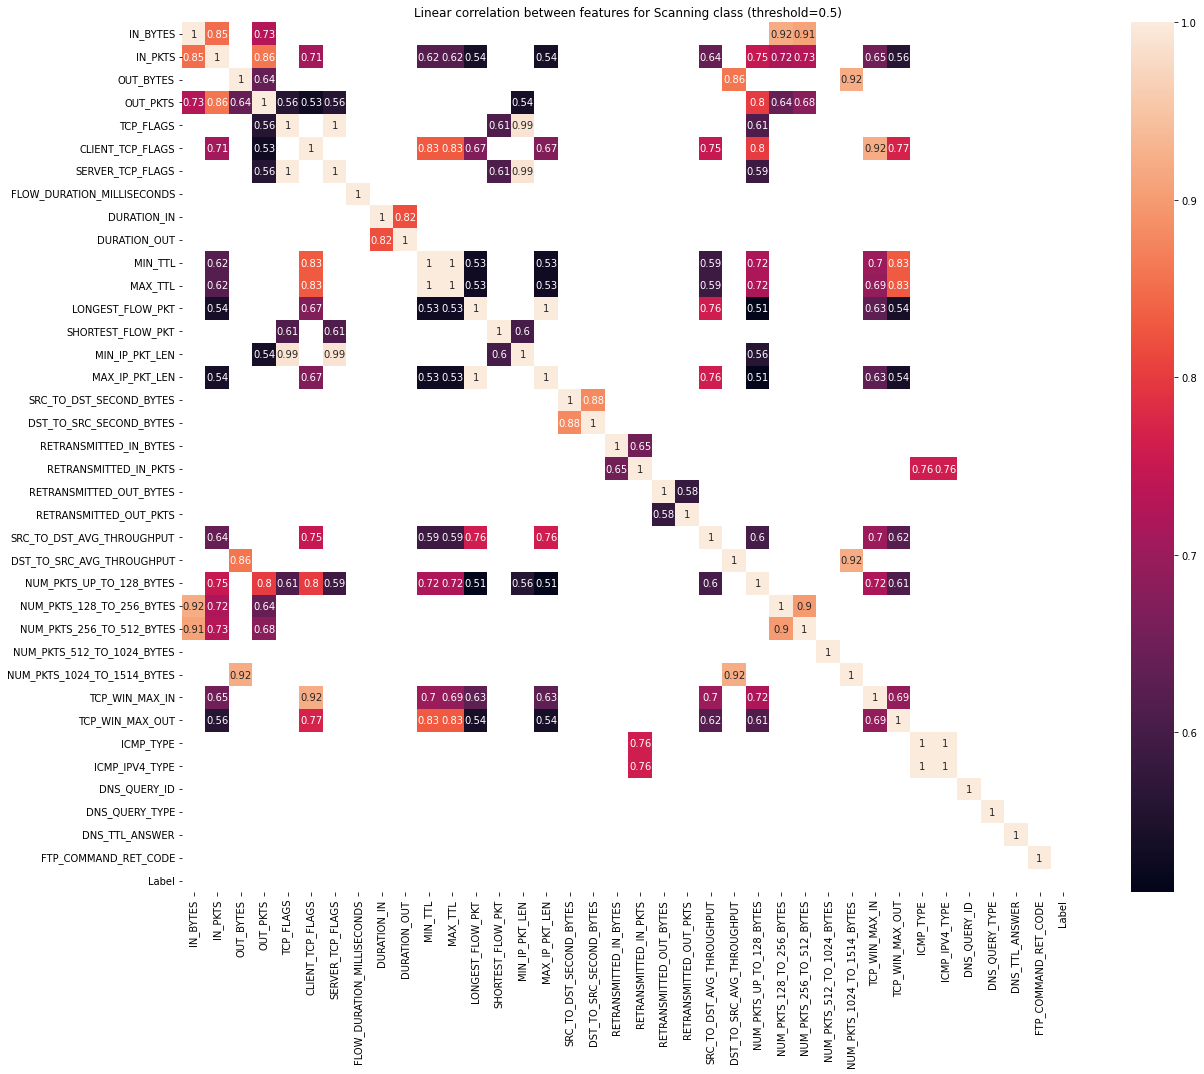

In [18]:
threshold = 0.5
high_corr = df_hist[df_hist.Label == 1].corr().abs().round(2)
high_corr_var = high_corr[high_corr>threshold]
plt.figure(figsize = (20,16))
plt.title("Linear correlation between features for Scanning class (threshold={})".format(threshold))
sns.heatmap(high_corr_var, xticklabels=high_corr_var.columns, yticklabels=high_corr_var.columns, annot=True);

## Linear correlation of features for _benign_ class (absolute value greater than 0.5)

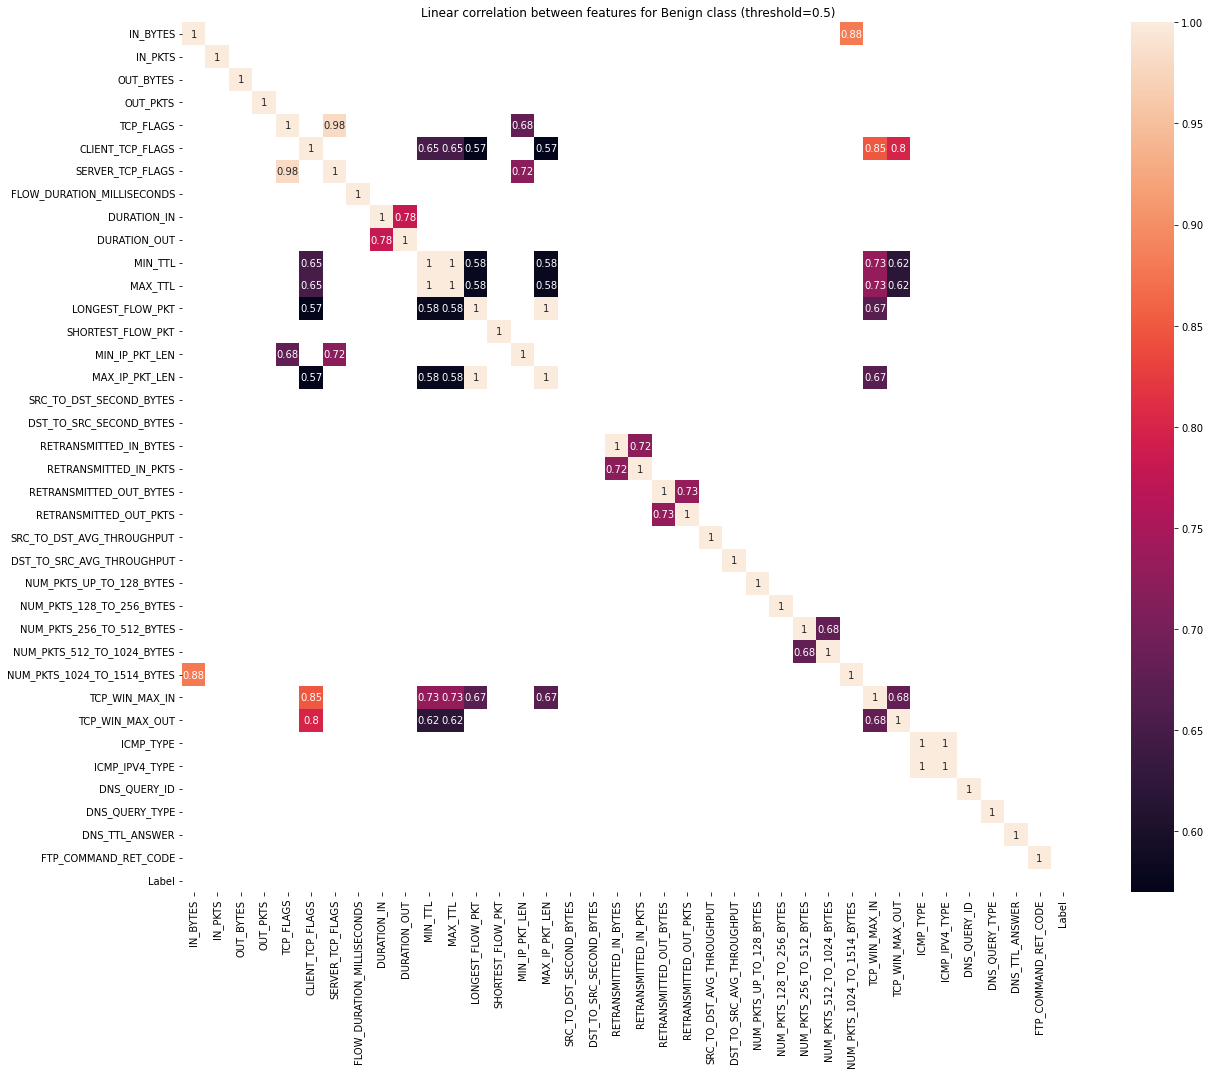

In [19]:
high_corr = df_hist[df_hist.Label == 0].corr().abs().round(2)
high_corr_var = high_corr[high_corr>threshold]
plt.figure(figsize = (20,16))
plt.title("Linear correlation between features for Benign class (threshold={})".format(threshold))
sns.heatmap(high_corr_var, xticklabels=high_corr_var.columns, yticklabels=high_corr_var.columns, annot=True);

---
# Data split / Silos

> **Premises**:
> - All agents share the same feature set
> - Each agent has access only to network traffic that are target to him
>
> HFL is applicable based on this premises. However, the share of common feature sets is a challenge that must be agreed up-front
>
> **Horizontally partitioned federated learning (HFL):** data distributed in different silos contain the _same feature space_ and _different samples_$^1$.
>
> $^1$ https://blog.openmined.org/federated-learning-types/

### Attention point for Non-IID
> Non-independently and identically distributed data, data across agents are not identically distributed

- Distribution skew between Agents (unbalance dataset)
- Quantity skew between Agents (number of samples)

In [20]:
df_top['IPV4_DST_ADDR'].unique()

array(['192.168.1.152', '192.168.1.193', '192.168.1.190', '192.168.1.1',
       '192.168.1.180', '192.168.1.49', '192.168.1.194', '192.168.1.46',
       '192.168.1.186', '192.168.1.195', '192.168.1.169', '192.168.1.133',
       '192.168.1.79'], dtype=object)

In [21]:
remove_columns = ['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO']

agent1 = df_top[df_top.IPV4_DST_ADDR == '192.168.1.152'].copy().drop(remove_columns, axis=1).reset_index(drop=True)
agent2 = df_top[df_top.IPV4_DST_ADDR == '192.168.1.193'].copy().drop(remove_columns, axis=1).reset_index(drop=True)
agent3 = df_top[df_top.IPV4_DST_ADDR == '192.168.1.190'].copy().drop(remove_columns, axis=1).reset_index(drop=True)
agent4 = df_top[df_top.IPV4_DST_ADDR == '192.168.1.1'].copy().drop(remove_columns, axis=1).reset_index(drop=True)
agent5 = df_top[df_top.IPV4_DST_ADDR == '192.168.1.180'].copy().drop(remove_columns, axis=1).reset_index(drop=True)
agent6 = df_top[df_top.IPV4_DST_ADDR == '192.168.1.49'].copy().drop(remove_columns, axis=1).reset_index(drop=True)
agent7 = df_top[df_top.IPV4_DST_ADDR == '192.168.1.194'].copy().drop(remove_columns, axis=1).reset_index(drop=True)
agent8 = df_top[df_top.IPV4_DST_ADDR == '192.168.1.46'].copy().drop(remove_columns, axis=1).reset_index(drop=True)
agent9 = df_top[df_top.IPV4_DST_ADDR == '192.168.1.186'].copy().drop(remove_columns, axis=1).reset_index(drop=True)
agent10 = df_top[df_top.IPV4_DST_ADDR == '192.168.1.195'].copy().drop(remove_columns, axis=1).reset_index(drop=True)
agent11 = df_top[df_top.IPV4_DST_ADDR == '192.168.1.169'].copy().drop(remove_columns, axis=1).reset_index(drop=True)
agent12 = df_top[df_top.IPV4_DST_ADDR == '192.168.1.133'].copy().drop(remove_columns, axis=1).reset_index(drop=True)
agent13 = df_top[df_top.IPV4_DST_ADDR == '192.168.1.79'].copy().drop(remove_columns, axis=1).reset_index(drop=True)

In [22]:
# for these two silos, the majority class is scanning (1), instead of benign (0) 
downsample1 = ["agent1", "agent11"]

---
### Training generic Logistic Regression model on each silo and compare the trained model against each other

In [23]:
def preprocess(X):
    cols = X.select_dtypes(include=[np.float64]).columns
    X[cols] = X[cols].astype(np.float32)

    X.fillna(0, inplace=True)
    X.replace(np.inf, 9999, inplace=True)
    
    return X

In [24]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import balanced_accuracy_score, make_scorer, f1_score, roc_auc_score, precision_score, recall_score, roc_curve

agents = {"agent1" : agent1, 
          "agent2" : agent2, 
          "agent3" : agent3, 
          "agent4" : agent4, 
          "agent5" : agent5, 
          "agent6" : agent6, 
          "agent7" : agent7, 
          "agent8" : agent8, 
          "agent9" : agent9, 
          "agent10" : agent10, 
          "agent11" : agent11, 
          "agent12" : agent12,
          "agent13" : agent13
         }

results = {}

for name, agent in agents.items():
    X = agent.drop(columns = ["Label"])
    y = agent.Label

    X = preprocess(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y) #stratified

    clf = SGDClassifier(random_state=seed, loss="log", class_weight="balanced")
    parameters = {}
    
    prep = StandardScaler() 
    # https://scikit-learn.org/0.24/common_pitfalls.html
    # https://machinelearningmastery.com/data-preparation-without-data-leakage/
    X_train = prep.fit_transform(X_train)
    clf.fit(X_train, y_train)
    
    X_test = prep.transform(X_test) 
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:,1] # for ROC curve, get just for positive class "1"
    
    score = f1_score(y_test, y_pred, average="binary") # binary only report results for the class 1 (pos_label)
        
    results[name] = {}
    results[name][name] = score
    
    print(name, set(y_test), set(y_pred), "{:.2f}".format(score))
    
    results[name]["accuracy"] = balanced_accuracy_score(y_test, y_pred)
    results[name]["precision"] = precision_score(y_test, y_pred, average="binary")
    results[name]["recall"] =  recall_score(y_test, y_pred, average="binary")
    results[name]["auc"] = roc_auc_score(y_test, y_pred)
    results[name]["fpr"], results[name]["tpr"], results[name]["thresholds"] = roc_curve(y_test, y_proba)
    results[name]["%benign"] = float("{:.3f}".format(sum(y==0)/len(y)))
    results[name]["%scan"] = float("{:.3f}".format(sum(y==1)/len(y)))
    results[name]["total_samples"] = len(y)
    
    for test_name, test_agent in agents.items():
        if test_name == name:
            continue
        
        X = test_agent.drop(columns = ["Label"])
        y = test_agent.Label
        X = preprocess(X)
        X = prep.transform(X)
        results[name][test_name] = f1_score(y, clf.predict(X), average="binary")

agent1 {0, 1} {0, 1} 0.96
agent2 {0, 1} {0, 1} 0.92
agent3 {0, 1} {0, 1} 0.90
agent4 {0, 1} {0, 1} 0.27
agent5 {0, 1} {0, 1} 0.98
agent6 {0, 1} {0, 1} 0.19
agent7 {0, 1} {0, 1} 0.86
agent8 {0, 1} {0, 1} 0.97
agent9 {0, 1} {0, 1} 0.97
agent10 {0, 1} {0, 1} 0.97
agent11 {0, 1} {0, 1} 0.95
agent12 {0, 1} {0, 1} 0.91
agent13 {0, 1} {0, 1} 0.72


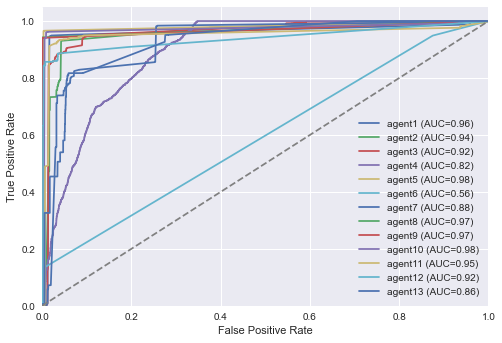

In [25]:
# https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.style.use('seaborn')
plt.figure()

index = 0
for model_key, result in results.items():
    fpr, tpr, thresholds = result["fpr"], result["tpr"], result["thresholds"]
    AUC = result["auc"]
    
    plt.plot(fpr, tpr, label="{} (AUC={:.2f})".format(model_key, AUC))
    index = index + 1
    
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")


In [26]:
all_values = []
for major_key in results.keys():
    values = []
    for key, value in sorted(results[major_key].items()):
        if key[:5] == "agent":
            values.append(value)
        
    all_values.append(values)

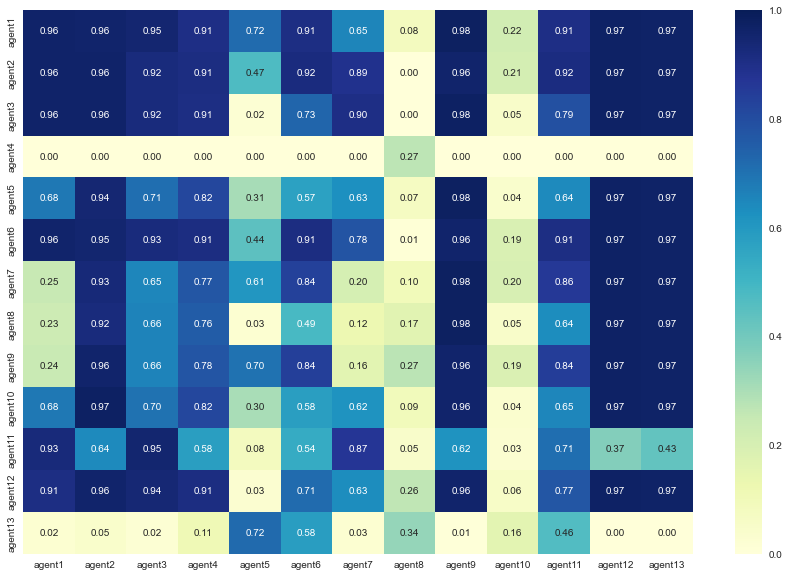

In [27]:
labels = [i for i in agents.keys()]
plt.figure(figsize = (15,10))
ax = sns.heatmap(all_values, vmin=0, vmax=1, annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels, cmap="YlGnBu")

In [28]:
results

{'agent1': {'agent1': 0.9638331052861145,
  'accuracy': 0.9643380723942301,
  'precision': 0.9788940942301624,
  'recall': 0.9492285421742047,
  'auc': 0.9643380723942302,
  'fpr': array([0.        , 0.00226915, 0.00241098, 0.00250553, 0.00252916,
         0.00254098, 0.00258825, 0.00262371, 0.00264735, 0.00265917,
         0.0026828 , 0.00271826, 0.00276553, 0.00283644, 0.00286008,
         0.00294281, 0.00296645, 0.00313191, 0.00316736, 0.00340373,
         0.00385284, 0.00385284, 0.0040183 , 0.0040183 , 0.00403011,
         0.00403011, 0.00416012, 0.00416012, 0.0049165 , 0.0049165 ,
         0.00508196, 0.00508196, 0.00536561, 0.00536561, 0.00600381,
         0.00600381, 0.00625199, 0.00625199, 0.00640564, 0.00640564,
         0.00648836, 0.00648836, 0.00668928, 0.00668928, 0.0084266 ,
         0.00846206, 0.00853297, 0.00860388, 0.00860388, 0.0090648 ,
         0.00908844, 0.00912389, 0.00917117, 0.00936026, 0.00937208,
         0.00999846, 0.0100221 , 0.01004574, 0.01016392, 0.010

---
# Federated Learning (Federated Averaging - _FedAvg_)

## Horizontal Federated Learning

### Define the _learning rate_ to be used

In [29]:
lr = 0.15

### Initialize FedAvg (global) model

In [30]:
fedavg = SGDClassifier(n_jobs=-1, random_state=seed, loss="log", learning_rate='constant', eta0=lr, verbose=0) # global

def init_global_model():
    # initialize global model
    features = agent1.drop(columns = ["Label"]).shape[1] # total number of features
    fedavg.intercept_ = np.zeros(1)
    fedavg.coef_ = np.zeros((1, features))
    fedavg.classes_ = np.array([0, 1])
    
init_global_model()

### Initialize agents/participants models

In [31]:
sgd_agent1 = SGDClassifier(n_jobs=-1, random_state=seed, loss="log", learning_rate='constant', eta0=lr, verbose=0)
sgd_agent2 = SGDClassifier(n_jobs=-1, random_state=seed, loss="log", learning_rate='constant', eta0=lr, verbose=0)
sgd_agent3 = SGDClassifier(n_jobs=-1, random_state=seed, loss="log", learning_rate='constant', eta0=lr, verbose=0)
sgd_agent4 = SGDClassifier(n_jobs=-1, random_state=seed, loss="log", learning_rate='constant', eta0=lr, verbose=0)
sgd_agent5 = SGDClassifier(n_jobs=-1, random_state=seed, loss="log", learning_rate='constant', eta0=lr, verbose=0)
sgd_agent6 = SGDClassifier(n_jobs=-1, random_state=seed, loss="log", learning_rate='constant', eta0=lr, verbose=0)
sgd_agent7 = SGDClassifier(n_jobs=-1, random_state=seed, loss="log", learning_rate='constant', eta0=lr, verbose=0)
sgd_agent8 = SGDClassifier(n_jobs=-1, random_state=seed, loss="log", learning_rate='constant', eta0=lr, verbose=0)
sgd_agent9 = SGDClassifier(n_jobs=-1, random_state=seed, loss="log", learning_rate='constant', eta0=lr, verbose=0)
sgd_agent10 = SGDClassifier(n_jobs=-1, random_state=seed, loss="log", learning_rate='constant', eta0=lr, verbose=0)
sgd_agent11 = SGDClassifier(n_jobs=-1, random_state=seed, loss="log", learning_rate='constant', eta0=lr, verbose=0)
sgd_agent12 = SGDClassifier(n_jobs=-1, random_state=seed, loss="log", learning_rate='constant', eta0=lr, verbose=0)
sgd_agent13 = SGDClassifier(n_jobs=-1, random_state=seed, loss="log", learning_rate='constant', eta0=lr, verbose=0)

In [32]:
# update each agent model by current global model values
def load_global_model(model):
    model.intercept_ = fedavg.intercept_.copy()
    model.coef_ = fedavg.coef_.copy()
    return model

In [33]:
def update_global_model(applicable_models, round_weights):
    # Average models parameters
    coefs = []
    intercept = []
    for model in applicable_models:
        coefs.append(model.coef_)
        intercept.append(model.intercept_)
    
    # average and update FedAvg (aggregator model)
    fedavg.coef_ = np.average(coefs, axis=0, weights=round_weights) # weight
    fedavg.intercept_ = np.average(intercept, axis=0, weights=round_weights) # weight

In [34]:
def train_local_agent(X, y, model, epochs, class_weight):
    for _ in range(0, epochs):
        model.partial_fit(X, y, classes=np.unique(y), sample_weight=class_weight)
    return model

### Define the number of rounds

> Each **round** is:
> - each agent copies global model
> - agent selects a subset (batch_size) from its silo
> - agent otimizes locally on the subset
> - agent send the parameters of its model for aggregation
> - perform FedAvg

In [35]:
rounds = 50

### Define the number of Epochs
> FedAvg requires a minimum number of training epochs before averaging
>
> For epoch=1 is the same as FedSGD (https://www.cs.cornell.edu/~shmat/shmat_ccs15.pdf)

In [36]:
epochs = 10

### Define the batch size

> This parameter represents how many sample will be retrieved from data silo. It is used by _train_test_split()_ as train_size attribute.
>
> If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the train split. 
>
> If int, represents the absolute number of train samples

In [37]:
batch_size=100 #0.05

### Define the sample_size
>
> This represents how many agents will be part of the Federated Learning setting, greater is better. In our case, the max is 13.

In [38]:
sample_size = 13 
remove_agents = []

## Calculate weights used by _FedAvg_ based on _scanning_ class imbalance

In [39]:
weights = []
for name, agent in agents.items():
    n_samples = agent.shape[0]
    scan = sum(agent["Label"] == 1)
    w = n_samples / (2 * scan)
    weights.append(w)

---
# Full evaluation

### Define the total number of iterations to evaluate the defined federated learning setup

In [40]:
n_iterations = 50

In [41]:
data = defaultdict(dict)

for i in tqdm(range(0, n_iterations), desc="trial"):
    init_global_model()
    
    for r in range(rounds):
        applicable_agents = random.sample(list(results.keys()), k=sample_size)

        applicable_models = []
        applicable_name = []

        # for calculating weighted average
        round_weights = []
        dataset_size = 0

        for name, agent in agents.items():
            if name in remove_agents:
                continue

            applicable_name.append(name)

            # rebalance datasets (agent6 is already balanced)
            if name in downsample1:
                downsampled_1 = resample(agent[agent.Label == 1], replace=False, n_samples=agent[agent.Label == 0].shape[0], random_state=1337)
                agent_balanced = pd.concat([downsampled_1, agent[agent.Label == 0]])
            else:
                downsampled_0 = resample(agent[agent.Label == 0], replace=False, n_samples=agent[agent.Label == 1].shape[0], random_state=1337)
                agent_balanced = pd.concat([downsampled_0, agent[agent.Label == 1]])
            

            X = agent_balanced.drop(columns = ["Label"])
            y = agent_balanced.Label

            X = preprocess(X)
            
            # required to set the random_state for reproductibility (random_state=seed+i+r)
            X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=batch_size, stratify=y, random_state=seed+i+r)
            X_train = prep.fit_transform(X_train)

            dataset_size += X_train.shape[0]

            sample_weights = compute_sample_weight('balanced', y=y_train)

            if name == "agent1":
                sgd_agent1 = load_global_model(sgd_agent1)
                sgd_agent1 = train_local_agent(X_train, y_train, sgd_agent1, epochs, sample_weights)
                round_weights.append(X_train.shape[0])
                applicable_models.append(sgd_agent1)

            elif name == "agent2":
                sgd_agent2 = load_global_model(sgd_agent2)
                sgd_agent2 = train_local_agent(X_train, y_train, sgd_agent2, epochs, sample_weights)
                round_weights.append(X_train.shape[0])
                applicable_models.append(sgd_agent2)

            elif name == "agent3":
                sgd_agent3 = load_global_model(sgd_agent3)
                sgd_agent3 = train_local_agent(X_train, y_train, sgd_agent3, epochs, sample_weights)
                round_weights.append(X_train.shape[0])
                applicable_models.append(sgd_agent3)

            elif name == "agent4":
                sgd_agent4 = load_global_model(sgd_agent4)
                sgd_agent4 = train_local_agent(X_train, y_train, sgd_agent4, epochs, sample_weights)
                round_weights.append(X_train.shape[0])
                applicable_models.append(sgd_agent4)

            elif name == "agent5":
                sgd_agent5 = load_global_model(sgd_agent5)
                sgd_agent5 = train_local_agent(X_train, y_train, sgd_agent5, epochs, sample_weights)
                round_weights.append(X_train.shape[0])
                applicable_models.append(sgd_agent5)

            elif name == "agent6":
                sgd_agent6 = load_global_model(sgd_agent6)
                sgd_agent6 = train_local_agent(X_train, y_train, sgd_agent6, epochs, sample_weights)
                round_weights.append(X_train.shape[0])
                applicable_models.append(sgd_agent6)

            elif name == "agent7":
                sgd_agent7 = load_global_model(sgd_agent7)
                sgd_agent7 = train_local_agent(X_train, y_train, sgd_agent7, epochs, sample_weights)
                round_weights.append(X_train.shape[0])
                applicable_models.append(sgd_agent7)

            elif name == "agent8":
                sgd_agent8 = load_global_model(sgd_agent8)
                sgd_agent8 = train_local_agent(X_train, y_train, sgd_agent8, epochs, sample_weights)
                round_weights.append(X_train.shape[0])
                applicable_models.append(sgd_agent8)

            elif name == "agent9":
                sgd_agent9 = load_global_model(sgd_agent9)
                sgd_agent9 = train_local_agent(X_train, y_train, sgd_agent9, epochs, sample_weights)
                round_weights.append(X_train.shape[0])
                applicable_models.append(sgd_agent9)
                
            elif name == "agent10":
                sgd_agent10 = load_global_model(sgd_agent10)
                sgd_agent10 = train_local_agent(X_train, y_train, sgd_agent10, epochs, sample_weights)
                round_weights.append(X_train.shape[0])
                applicable_models.append(sgd_agent10)
                
            elif name == "agent11":
                sgd_agent11 = load_global_model(sgd_agent11)
                sgd_agent11 = train_local_agent(X_train, y_train, sgd_agent11, epochs, sample_weights)
                round_weights.append(X_train.shape[0])
                applicable_models.append(sgd_agent11)
                
            elif name == "agent12":
                sgd_agent12 = load_global_model(sgd_agent12)
                sgd_agent12 = train_local_agent(X_train, y_train, sgd_agent12, epochs, sample_weights)
                round_weights.append(X_train.shape[0])
                applicable_models.append(sgd_agent12)
                
            elif name == "agent13":
                sgd_agent13 = load_global_model(sgd_agent13)
                sgd_agent13 = train_local_agent(X_train, y_train, sgd_agent13, epochs, sample_weights)
                round_weights.append(X_train.shape[0])
                applicable_models.append(sgd_agent13)

        # Update global model (FedAvg) after each round
        round_weights = np.array(round_weights) / dataset_size # calculate weight based on actual dataset size
        round_weights = weights
        update_global_model(applicable_models, round_weights)
    
    ################################################################
    ### calculate the mean over the n_iterations
    ################################################################
    for name, agent in agents.items():
    
        if name in remove_agents:
                continue

        score_fedavg = []
        score_local = []
        
        # rebalance datasets (agent6 is already balanced)
        if name in downsample1:
            downsampled_1 = resample(agent[agent.Label == 1], replace=False, n_samples=agent[agent.Label == 0].shape[0], random_state=1337)
            agent_balanced = pd.concat([downsampled_1, agent[agent.Label == 0]])
        else:
            downsampled_0 = resample(agent[agent.Label == 0], replace=False, n_samples=agent[agent.Label == 1].shape[0], random_state=1337)
            agent_balanced = pd.concat([downsampled_0, agent[agent.Label == 1]])


        X = agent_balanced.drop(columns = ["Label"])
        y = agent_balanced.Label

        X = preprocess(X)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

        X_train = prep.fit_transform(X_train)    
        X_test = prep.transform(X_test) 

        y_pred = fedavg.predict(X_test)
        score_fedavg.append(f1_score(y_test, y_pred, average="binary")) # binary only report results for the class 1 (pos_label)

        if name == "agent1":
            y_pred = sgd_agent1.predict(X_test)
            score_local.append(f1_score(y_test, y_pred, average="binary"))
        elif name == "agent2":
            y_pred = sgd_agent2.predict(X_test)
            score_local.append(f1_score(y_test, y_pred, average="binary"))
        elif name == "agent3":
            y_pred = sgd_agent3.predict(X_test)
            score_local.append(f1_score(y_test, y_pred, average="binary"))
        elif name == "agent4":
            y_pred = sgd_agent4.predict(X_test)
            score_local.append(f1_score(y_test, y_pred, average="binary"))
        elif name == "agent5":
            y_pred = sgd_agent5.predict(X_test)
            score_local.append(f1_score(y_test, y_pred, average="binary"))
        elif name == "agent6":
            y_pred = sgd_agent6.predict(X_test)
            score_local.append(f1_score(y_test, y_pred, average="binary"))
        elif name == "agent7":
            y_pred = sgd_agent7.predict(X_test)
            score_local.append(f1_score(y_test, y_pred, average="binary"))
        elif name == "agent8":
            y_pred = sgd_agent8.predict(X_test)
            score_local.append(f1_score(y_test, y_pred, average="binary"))
        elif name == "agent9":
            y_pred = sgd_agent9.predict(X_test)
            score_local.append(f1_score(y_test, y_pred, average="binary"))
        elif name == "agent10":
            y_pred = sgd_agent10.predict(X_test)
            score_local.append(f1_score(y_test, y_pred, average="binary"))
        elif name == "agent11":
            y_pred = sgd_agent11.predict(X_test)
            score_local.append(f1_score(y_test, y_pred, average="binary"))
        elif name == "agent12":
            y_pred = sgd_agent12.predict(X_test)
            score_local.append(f1_score(y_test, y_pred, average="binary"))
        elif name == "agent13":
            y_pred = sgd_agent13.predict(X_test)
            score_local.append(f1_score(y_test, y_pred, average="binary"))

        data[i]["fedavg_"+name] = score_fedavg
        data[i]["locals_"+name] = score_local

trial:   0%|          | 0/50 [00:00<?, ?it/s]

---
# Analysis of the results

In [42]:
import json
file = './data_ton-iot_scan.json' 
with open(file, 'w') as f: 
    json.dump(data, f)

In [43]:
all_fed_avg = []
all_locals = []
mean_fed_avg = []
mean_locals = []

for i in range(0,50):
    tot_fed = 0
    tot_loc = 0

    for key, value in data[i].items():
        #print(i, key[:6])
        if key[:6] == "fedavg":
            all_fed_avg.append(value[0])
            tot_fed += value[0]
        elif key[:6] == "locals":
            all_locals.append(value[0])
            tot_loc += value[0]
            
    mean_fed_avg.append(tot_fed/13)
    mean_locals.append(tot_loc/13)
            
        

C:\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


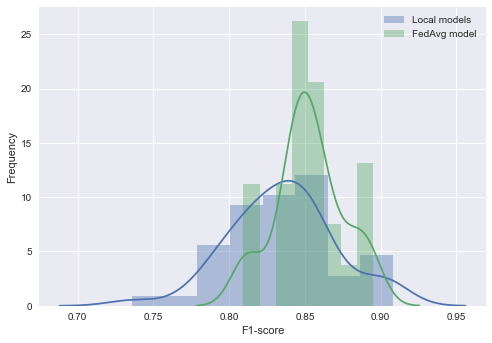

In [51]:
fig, ax = plt.subplots()
ax.set(xlabel='F1-score', ylabel='Frequency')
#ax.set_title('FedAvg vs Local model performance')
sns.distplot(mean_locals, ax=ax, kde=True, label="Local models")
sns.distplot(mean_fed_avg, ax=ax, kde=True, label="FedAvg model")
ax.legend()
#fig.savefig('./images/fedavg_vs_locals_scanning.pdf', dpi=300, bbox_inches="tight")

In [45]:
print("Mean local models:", round(np.mean(mean_locals),2), round(np.std(mean_locals),2))
print("Mean FedAvg model to 13 agents:", round(np.mean(mean_fed_avg), 2), round(np.std(mean_fed_avg), 2)) 
print("F1-score increase - FedAvg vs. Locals:", round((np.mean(mean_fed_avg)/np.mean(mean_locals)-1)*100,2),"%")

Mean local models: 0.84 0.03
Mean FedAvg model to 13 agents: 0.85 0.02
F1-score increase - FedAvg vs. Locals: 2.12 %


In [46]:
ttest, pval = ttest_ind(mean_locals, mean_fed_avg)
print("statistically significant:", pval < 0.01)
print("p =", pval)

statistically significant: True
p = 0.003126275624854447


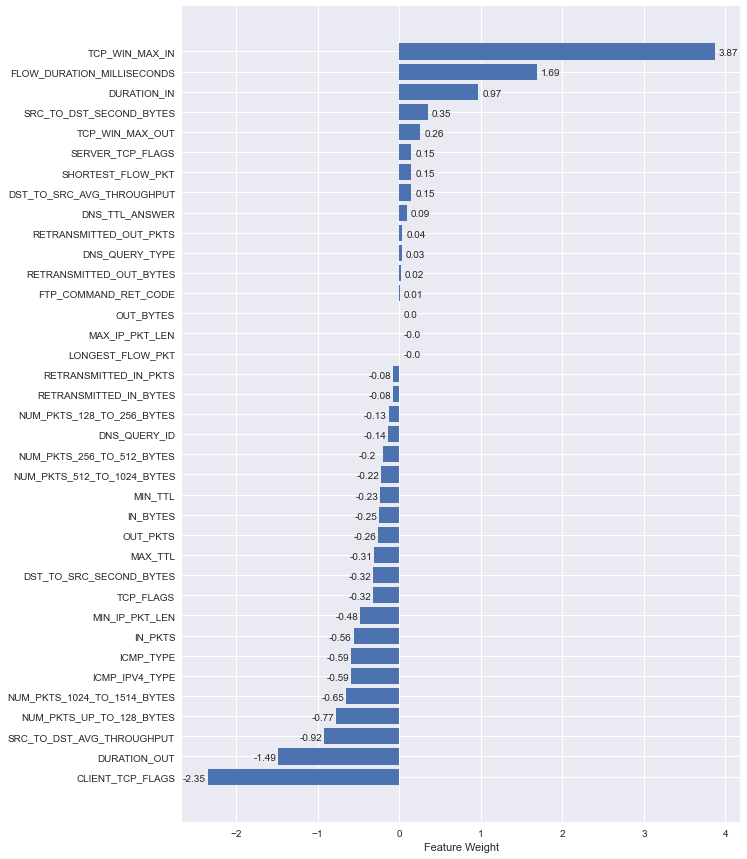

In [53]:
# comparing the feature importance of global model vs. local models (all or top #5)
a = fedavg.coef_ #sgd_agent1.coef_

lr_weights = []
lr_features = []

for i in np.argsort(a):
    for k in reversed(i):
        #print(k, X.columns.values[k], round(a[0, k],2))
        lr_weights.append(round(a[0, k],2))
        lr_features.append(X.columns.values[k])

fig, ax = plt.subplots(figsize=(10,15))
y_pos = np.arange(len(lr_features))

ax.barh(y_pos, lr_weights, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(lr_features)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature Weight')

for i, v in enumerate(lr_weights):
    if v >= 0:
        ax.text(v + 0.05, i + 0.2, str(v))
    else:
        ax.text(v - 0.3, i + 0.2, str(v))


#fig.savefig('./images/fedavg_feature_importance.pdf', dpi=300, bbox_inches="tight")
plt.show()


In [48]:
# calculate the average of FedAvg and Local for each Agent


agents_data = {
    "agent1" : {"fed" : [], "local": []},
    "agent2" : {"fed" : [], "local": []},
    "agent3" : {"fed" : [], "local": []},
    "agent4" : {"fed" : [], "local": []},
    "agent5" : {"fed" : [], "local": []},
    "agent6" : {"fed" : [], "local": []},
    "agent7" : {"fed" : [], "local": []},
    "agent8" : {"fed" : [], "local": []},
    "agent9" : {"fed" : [], "local": []},
    "agent10" : {"fed" : [], "local": []},
    "agent11" : {"fed" : [], "local": []},
    "agent12" : {"fed" : [], "local": []},
    "agent13" : {"fed" : [], "local": []}
}

for i in range(0, n_iterations):
    for key, value in data[i].items():
        if key[-7:] == "_agent1":
            if key[:6] == "fedavg":
                agents_data[key[-6:]]["fed"].append(value[0])
            elif key[:6] == "locals":
                agents_data[key[-6:]]["local"].append(value[0])
        elif key[-7:] == "_agent2":
            if key[:6] == "fedavg":
                agents_data[key[-6:]]["fed"].append(value[0])
            elif key[:6] == "locals":
                agents_data[key[-6:]]["local"].append(value[0])
        elif key[-7:] == "_agent3":
            if key[:6] == "fedavg":
                agents_data[key[-6:]]["fed"].append(value[0])
            elif key[:6] == "locals":
                agents_data[key[-6:]]["local"].append(value[0])
        elif key[-7:] == "_agent4":
            if key[:6] == "fedavg":
                agents_data[key[-6:]]["fed"].append(value[0])
            elif key[:6] == "locals":
                agents_data[key[-6:]]["local"].append(value[0])
        elif key[-7:] == "_agent5":
            if key[:6] == "fedavg":
                agents_data[key[-6:]]["fed"].append(value[0])
            elif key[:6] == "locals":
                agents_data[key[-6:]]["local"].append(value[0])
        elif key[-7:] == "_agent6":
            if key[:6] == "fedavg":
                agents_data[key[-6:]]["fed"].append(value[0])
            elif key[:6] == "locals":
                agents_data[key[-6:]]["local"].append(value[0])
        elif key[-7:] == "_agent7":
            if key[:6] == "fedavg":
                agents_data[key[-6:]]["fed"].append(value[0])
            elif key[:6] == "locals":
                agents_data[key[-6:]]["local"].append(value[0])
        elif key[-7:] == "_agent8":
            if key[:6] == "fedavg":
                agents_data[key[-6:]]["fed"].append(value[0])
            elif key[:6] == "locals":
                agents_data[key[-6:]]["local"].append(value[0])
        elif key[-7:] == "_agent9":
            if key[:6] == "fedavg":
                agents_data[key[-6:]]["fed"].append(value[0])
            elif key[:6] == "locals":
                agents_data[key[-6:]]["local"].append(value[0])
        elif key[-8:] == "_agent10":
            if key[:6] == "fedavg":
                agents_data[key[-7:]]["fed"].append(value[0])
            elif key[:6] == "locals":
                agents_data[key[-7:]]["local"].append(value[0])
        elif key[-8:] == "_agent11":
            if key[:6] == "fedavg":
                agents_data[key[-7:]]["fed"].append(value[0])
            elif key[:6] == "locals":
                agents_data[key[-7:]]["local"].append(value[0])
        elif key[-8:] == "_agent12":
            if key[:6] == "fedavg":
                agents_data[key[-7:]]["fed"].append(value[0])
            elif key[:6] == "locals":
                agents_data[key[-7:]]["local"].append(value[0])
        elif key[-8:] == "_agent13":
            if key[:6] == "fedavg":
                agents_data[key[-7:]]["fed"].append(value[0])
            elif key[:6] == "locals":
                agents_data[key[-7:]]["local"].append(value[0])
            


In [49]:
mean_agents = deepcopy(agents_data)

for key, item in mean_agents.items():
    mean_agents[key]["fed"] = round(mean(mean_agents[key]["fed"]),2)
    mean_agents[key]["local"] = round(mean(mean_agents[key]["local"]),2)
    mean_agents[key]["%"] = round((round(mean_agents[key]["fed"]/mean_agents[key]["local"],2) - 1)*100,2)
    
mean_agents

{'agent1': {'fed': 0.94, 'local': 0.88, '%': 7.0},
 'agent2': {'fed': 0.93, 'local': 0.91, '%': 2.0},
 'agent3': {'fed': 0.86, 'local': 0.79, '%': 9.0},
 'agent4': {'fed': 0.64, 'local': 0.73, '%': -12.0},
 'agent5': {'fed': 0.98, 'local': 0.98, '%': 0.0},
 'agent6': {'fed': 0.32, 'local': 0.38, '%': -16.0},
 'agent7': {'fed': 0.88, 'local': 0.78, '%': 13.0},
 'agent8': {'fed': 0.97, 'local': 0.97, '%': 0.0},
 'agent9': {'fed': 0.97, 'local': 0.97, '%': 0.0},
 'agent10': {'fed': 0.95, 'local': 0.94, '%': 1.0},
 'agent11': {'fed': 0.89, 'local': 0.77, '%': 16.0},
 'agent12': {'fed': 0.92, 'local': 0.89, '%': 3.0},
 'agent13': {'fed': 0.83, 'local': 0.85, '%': -2.0}}

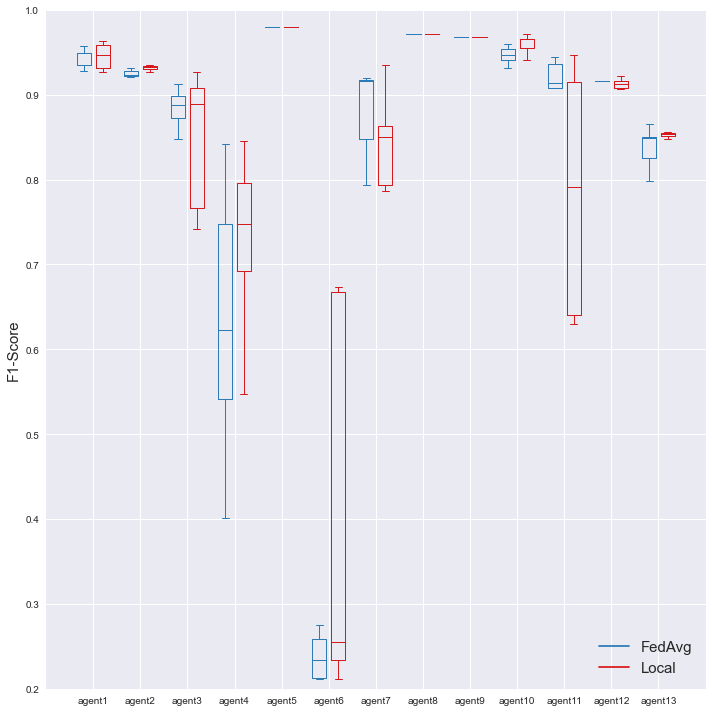

In [60]:
feds = []
locs = []
ticks = []


for key, items in agents_data.items():
    ticks.append(key)
    feds.append(items["fed"])
    locs.append(items["local"])

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

bpl = plt.boxplot(feds, positions=np.array(range(len(feds)))*2.0-0.4, widths=0.6, sym='') # sym='', 
bpr = plt.boxplot(locs, positions=np.array(range(len(locs)))*2.0+0.4, widths=0.6, sym='') # sym='', 
set_box_color(bpl, '#2C7BB6') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#D7191C')

# draw temporary red and blue lines and use them to create a legend
#plt.rcParams.update({'font.size': 40})
#plt.rc('xtick', labelsize=20) 
#plt.rc('ytick', labelsize=20)
plt.plot([], c='#2C7BB6', label='FedAvg')
plt.plot([], c='#D7191C', label='Local')
plt.legend(loc='lower right', prop={'size': 15})
plt.ylabel('F1-Score', fontsize=15)
plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.ylim(0.2, 1)
#plt.rcParams["figure.figsize"] = (10,10)
#plt.savefig('./images/fedavg_vs_locals_scanning_boxplot_agent_by_agent.pdf', dpi=300, bbox_inches="tight")
plt.tight_layout()